# Exercise 4: Python Scripts, Concept of Grains, Display, Markdown,
* Cleaning and analyzing data takes a lot of time, patience, and skill.
* However, presenting the data to stakeholders is also equaly important.
* At DDS, we often present our work in a Jupyter Notebook.
* This exercise will walk you through how we do so. 

In [1]:
import _starterkit_utils
import altair as alt
import numpy as np
import pandas as pd
from calitp_data_analysis import calitp_color_palette

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

## Python Scripts
* Up until now, we have been placing all of our code in the Jupyter Notebook.
* While this is convenient, it's not the best practice. 
* A notebook full of code isn't easy for viewers - it gets chaotic, quickly! 
* Jupyter notebooks are also very difficult for Git to version control. 
* **The best solution is to move the bulk of your code when you have reached a stopping point to a Python Script.**
    * Read all about the benefits of scripts [here in our DDS docs](https://docs.calitp.org/data-infra/analytics_tools/scripts.html).
    * Summary points from the docs page above:
        * <i>Python scripts (.py) are plain text files. Git tracks plain text changes easily.</i>
        * <i>Scripts are robust to scaling and reproducing work.</i>
        * <i>Break out scripts by concepts / stages</i>
        * <i>All functions used in scripts should have docstrings. Type hints are encouraged!</i>
* Making Python scripts is an art and not straight forward.
* I have already populated a `.py` file called `_starterkit_utils` with some sample functions.
* I imported my Python Script just like how I imported my other dependencies (Pandas, Altair, Numpy).

In [3]:
import _starterkit_utils

### Breakdown of a Script.
#### Function 1
* You can also preview what a function does by writing `script_name.function_name??`

* Following what the DDS docs says, I am creating a new function every time I am processing the data in another stage.
* I have one function that loads in my dataset.

In [4]:
_starterkit_utils.load_dataset??

Signature: _starterkit_utils.load_dataset() -> pandas.core.frame.DataFrame
Source:   
def load_dataset()->pd.DataFrame:
    """
    Load the final dataframe.
    """
    GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/starter_kit/"
    FILE = "starter_kit_example_categorized.parquet"
    
    # Read dataframe in
    df = pd.read_parquet(f"{GCS_FILE_PATH}{FILE}")
    
    # Capitalize the Scope of Work column again since it is all lowercase
    df.scope_of_work = df.scope_of_work.str.capitalize()
    
    # Clean up the column names
    df = reverse_snakecase(df)
    return df
File:      ~/data-analyses/starter_kit/_starterkit_utils.py
Type:      function


* To use a function in a Script, write `name_of_your_script.name_of_the_function(whatever arguments)`
* Take a look at the column names: they are no longer in `snakecase` because I applied a function that capitalizes it properly.

In [5]:
df = _starterkit_utils.load_dataset()

#### Function 2:
* After loading in the dataset from GCS, I am entering my second stage of processing the data.
* I am aggregating my dataframe by category. 

In [6]:
_starterkit_utils.aggregate_by_category??

Signature: _starterkit_utils.aggregate_by_category(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Source:   
def aggregate_by_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find the median overall score and project cost 
    and total unique projects by category.
    """
    agg1 = (
        df.groupby(["Category"])
        .aggregate(
            {
                "Overall Score": "median",
                "Project Cost": "median",
                "Project Name": "nunique",
            }
        )
        .reset_index()
        .rename(
            columns={
                "Overall Score": "Median Score",
                "Project Cost": "Median Project Cost",
                "Project Name": "Total Projects",
            }
        )
    )
    
    # Format the Cost column properly
    agg1['Median Project Cost'] = agg1['Median Project Cost'].apply(lambda x: '${:,.0f}'.format(x))
    
    return agg1
File:      ~/data-analyses/starter_kit/_starterkit_utils.py


In [7]:
aggregated_df = _starterkit_utils.aggregate_by_category(df)

In [8]:
aggregated_df

,Category,Median Score,Median Project Cost,Total Projects
0,ATP,72.00,"$4,991,255",11
1,General Lanes,73.00,"$7,487,963",7
2,General Lanes and ATP,82.00,"$5,672,550",2
3,Other,73.00,"$3,708,858",15
4,Transit,75.00,"$4,399,886",8
5,Transit and ATP,75.00,"$2,069,143",1


#### Function 3
* I want to swap my dataframe from wide to long. 
* [Read about wide to long.](https://www.statology.org/long-vs-wide-data/)
* [Pandas doc on melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html)

In [9]:
_starterkit_utils.wide_to_long??

Signature: _starterkit_utils.wide_to_long(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Source:   
def wide_to_long(df:pd.DataFrame)->pd.DataFrame:
    """
    Change the dataframe from wide to long based on the project name and
    Caltrans District.
    """
    df2 = pd.melt(
    df,
    id_vars=["CalTrans District","Project Name"],
    value_vars=[
        "Accessibility Score",
        "DAC Accessibility Score",
        "DAC Traffic Impacts Score",
        "Freight Efficiency Score",
        "Freight Sustainability Score",
        "Mode Shift Score",
        "Landuse Natural Resources Score",
        "Safety Score",
        "VMT Score",
        "ZEV Score",
        "Public Engagement Score",
        "Climate Resilience Score",
        "Program Fit Score",
    ])
    
    df2 = df2.rename(columns = {'variable':'Metric',
                                'value':'Score'})
    return df2
File:      ~/data-analyses/starter_kit/_starterkit_utils.py
Type:      function

In [10]:
df2 = _starterkit_utils.wide_to_long(df)

In [11]:
df2.head(2)

,CalTrans District,Project Name,Metric,Score
0,1,Meadow Magic Multi-Use Path,Accessibility Score,2
1,4,Bunny Hop Bike Boulevard,Accessibility Score,3


#### Function 4
* Now that I have my aggregated data, I want to visualize my results,
* `style_df` takes my pandas dataframe and makes it look a bit sleeker.

In [12]:
_starterkit_utils.style_df(aggregated_df)

Category,Median Score,Median Project Cost,Total Projects
ATP,72,"$4,991,255",11
General Lanes,73,"$7,487,963",7
General Lanes and ATP,82,"$5,672,550",2
Other,73,"$3,708,858",15
Transit,75,"$4,399,886",8
Transit and ATP,75,"$2,069,143",1


#### Function 5 
* This is function that creates a chart that shows the scores by metric for each project.

In [13]:
_starterkit_utils.create_metric_chart??

Signature: _starterkit_utils.create_metric_chart(df: pandas.core.frame.DataFrame) -> altair.vegalite.v5.api.Chart
Source:   
def create_metric_chart(df: pd.DataFrame) -> alt.Chart:
    """
    Create a chart that displays metric scores
    for each project.
    """
    # Create dropdown
    metrics_list = df["Metric"].unique().tolist()

    metrics_dropdown = alt.binding_select(
        options=metrics_list,
        name="Metrics: ",
    )
    # Column that controls the bar charts
    xcol_param = alt.selection_point(
        fields=["Metric"], value=metrics_list[0], bind=metrics_dropdown
    )

    chart = (
        alt.Chart(df, title="Metric by Categories")
        .mark_circle(size=200)
        .encode(
            x=alt.X("Score", scale=alt.Scale(domain=[0, 10])),
            y=alt.Y("Project Name"),
            color=alt.Color(
                "Score",
                scale=alt.Scale(
                    range=calitp_color_palette.CALITP_CATEGORY_BRIGHT_COLORS
                ),


In [14]:
_starterkit_utils.create_metric_chart(df2)

alt.Chart(...)

## Grains
* This is a light introduction to the concept of grains.
* Grain means the level your dataset is presented at.
* You can think of it as: what does each row represent?
* The original dataset is presented on the project-level grain because each row represents a unique project. 


In [15]:
df[["Project Name", "Overall Score"]].head()

,Project Name,Overall Score
0,Meadow Magic Multi-Use Path,72
1,Bunny Hop Bike Boulevard,68
2,Strawberry Shortcake Sidewalks,87
3,River Ramble Rabbit Trail,75
4,Lilac Lane Dream Complete Street,72


* If we aggregate the dataset using Caltrans District, then this dataset would be on the district gain.

In [16]:
df.groupby(["CalTrans District"]).agg({"Project Name": "nunique"}).reset_index().rename(
    columns={"Project Name": "Total Projects"}
)

,CalTrans District,Total Projects
0,1,1
1,2,2
2,3,6
3,4,6
4,5,4
5,6,3
6,7,3
7,8,5
8,9,3
9,10,2


* If we aggregate the dataset by lead agency, then this dataset would be on the agency gain.

In [17]:
df.groupby(["Lead Agency"]).agg({"Project Name": "nunique"}).reset_index().rename(
    columns={"Project Name": "Total Projects"}
)

,Lead Agency,Total Projects
0,Bunny's Meadow Hop Transportation (BMHT),3
1,Cherry Metro Services (CMS),1
2,Dewdrop Ride Transit,2
3,Elf's Efficient Transportation (EET),3
4,Fairy Creek Public Transit (FCPT),5
5,Gnome Valley Rail Link (GVRL),3
6,Meadow Bunny Public Transportation (MBPT),4
7,Morning Dewdrop Transit (MDT),4
8,Mushroom Metro Transit Agency (MMTA),5
9,Rainbow Mushroom Transportation Corporation (RMTC),5


* Grains can get very complicated. The one below is Lead Agency and Category Grain. 

In [30]:
df.groupby(["Lead Agency", "Category"]).agg({"Project Name": "nunique"}).reset_index().rename(
    columns={"Project Name": "Total Projects"}
)

,Lead Agency,Category,Total Projects
0,Bunny's Meadow Hop Transportation (BMHT),Other,2
1,Bunny's Meadow Hop Transportation (BMHT),Transit,1
2,Cherry Metro Services (CMS),Other,1
3,Dewdrop Ride Transit,ATP,1
4,Dewdrop Ride Transit,Other,1
5,Elf's Efficient Transportation (EET),ATP,1
6,Elf's Efficient Transportation (EET),General Lanes,1
7,Elf's Efficient Transportation (EET),Transit,1
8,Fairy Creek Public Transit (FCPT),ATP,1
9,Fairy Creek Public Transit (FCPT),Other,2


## Create your own Script
* **Make sure your functions make sense for the district grain.**
* You will be using these functions for Exercise 5. 
* Make sure to separate out functions by theme. 
    * One function that loads the dataset and does some light cleaning.
    * One (or more) functions that transform your dataframe.
        * `melt()`, `.T`, `.groupby()` are just some of the many options available through `pandas`. 
    * One (or more) functions that visualize your dataframe.
        * Could be a chart, a styled dataframe, a wordcloud. 
* Other things to consider
    * Our [DDS Docs](https://docs.calitp.org/data-infra/publishing/sections/4_notebooks_styling.html#narrative) has a great guide on what "checkboxes" need to be "checked" when presenting data. The first 3 sections are the most relevant.
    * To summarize the docs, double check:
        * Are the currency columns formatted with $ and commas?
        * Are all the scores formatted with the same number of decimals?
        * Are the string columns formatted with the right punctuation and capitalization?
        * Are the column names formatted properly? While `snake_case` is very handy when we are analyzing the dataframe, it is not slightly when presenting the data. We typically reverse the `snake_case` back to something like `Project Name`.
        * [CalTrans Districts are currently integers, but they have actual names that can be mapped.](https://cwwp2.dot.ca.gov/documentation/district-map-county-chart.htm) 
   

## Markdown/Display
* Although our code is now neatly stored in a Python script, a Jupyter Notebook on its own is a bit plain, even when we have beautiful charts. 
* There are many ways to jazz it up.
* **Resource**: [Data Camp](https://www.datacamp.com/tutorial/markdown-in-jupyter-notebook)

#### Images
* You can add an image in a markdown cell
`<img src="https://raw.githubusercontent.com/cal-itp/data-analyses/refs/heads/main/portfolio/Calitp_logo_MAIN.png" width=100 height=100 />`<p>
<img src="https://raw.githubusercontent.com/cal-itp/data-analyses/refs/heads/main/portfolio/Calitp_logo_MAIN.png" width=100 height=100 />
* You can add an image in a code cell if you import the packages below.

In [18]:
from IPython.display import HTML, Image, Markdown, display, display_html

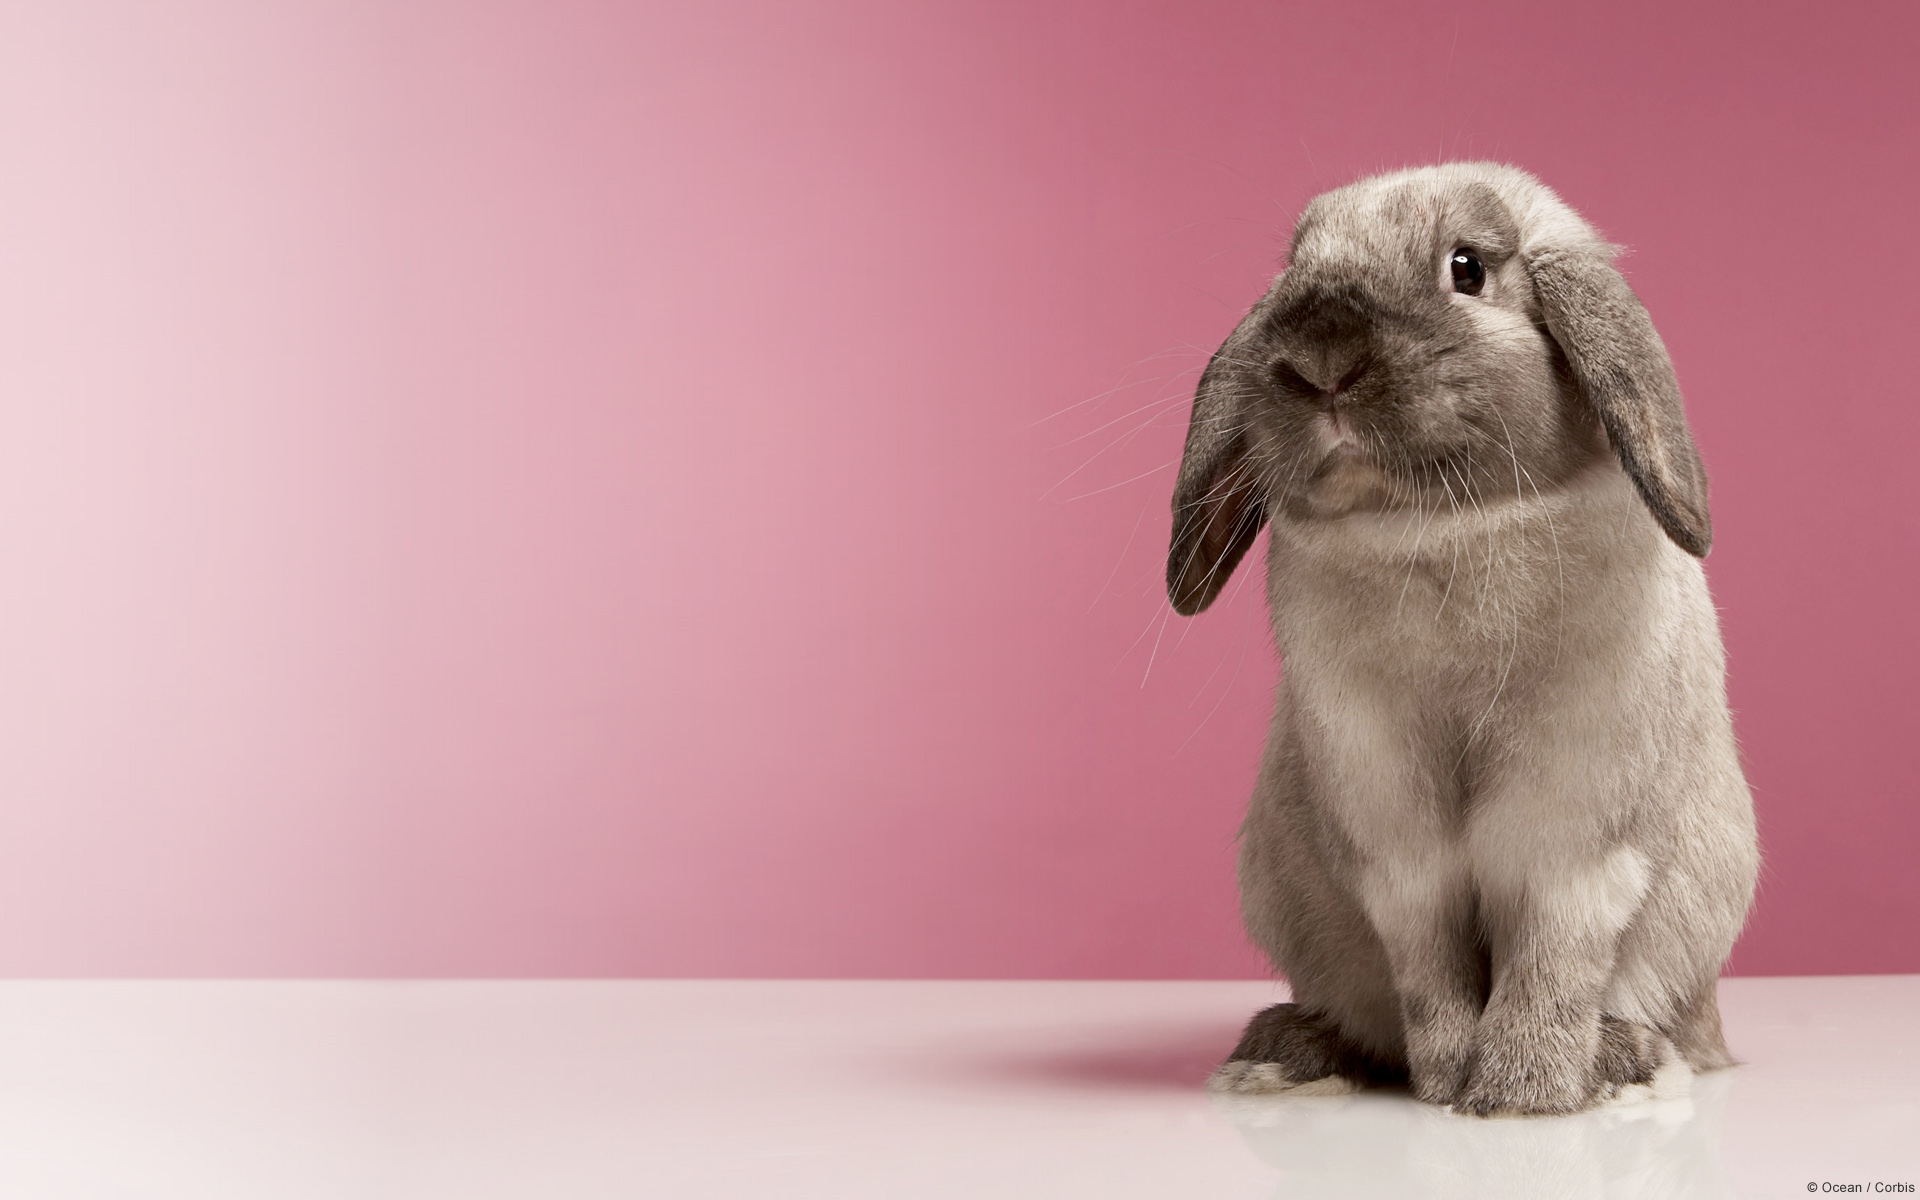

In [19]:
display(Image(filename="./19319_en_1.jpg", retina=True))

### Display
* Of course, you can write your narratives in a Markdown cell like what I'm doing right now.
* However, what if you want to incorporate values from your dataframe into the narrative?
* Writing out the values manually in markdown locks you in. If the values change, you'll have to rewrite your narrative.
* The best way is to use `display` and `markdown` from  `from IPython.display`
* We are using District 3 as an example

#### No hard coding
* Save out your desired value into a new variable if you are manipulating it.

In [20]:
# Filter for D3
d3_df = df.loc[df["CalTrans District"] == 3].reset_index(drop=True)

In [21]:
# Find the median overall score
d3_median_score = d3_df["Overall Score"].median()

In [22]:
# Find total projects
d3_total_projects = d3_df["Project Name"].nunique()

In [23]:
# Find the most expensive project
d3_max_project = d3_df["Project Cost"].max()

In [24]:
# Format the cost so it's something like $1,000,000 instead of 1000000
d3_max_project = f"${d3_max_project:,.2f}"

#### Long F-String + Headers
* The f-string has multiple quotation marks. This allows you to write a f-string that goes over multiple lines.
* <h3> and </h3> displays District 3 in a header. Headers vary in size, 1 being the largest. 
* `<b></b>` bolds the text. 
    * `<i></i> italicizes the text.
* Notice that you always have to **close** your HTML with `</whatever_you_are_doing`

In [25]:
display(
    Markdown(
        f"""<h3>District 3</h3>
        The median score for projects in District 3 is <b>{d3_median_score}</b><br> 
        The total number of projects is <b>{d3_total_projects}</b><br>
        The most expensive project costs <b>{d3_max_project}</b>
        """
    )
)

<h3>District 3</h3>
        The median score for projects in District 3 is <b>80.5</b><br> 
        The total number of projects is <b>6</b><br>
        The most expensive project costs <b>$9,448,022.00</b>
        

* You can code in this cell. I'm filtering out for district 3 values.
* Notice the header went from `<h3>` to `<h4>`. 

In [27]:
display(
    Markdown(
        f"""<h4>Metric Scores</h4>
        """
    )
)
display(_starterkit_utils.create_metric_chart(df2))

<h4>Metric Scores</h4>
        

alt.Chart(...)

### This can be a function too
* What if I wanted to generate these narratives for every district?
* I can simply turn this into a function.
* I only want to print out a couple of districts or else this notebook will become too large

In [28]:
_starterkit_utils.create_district_summary??

Signature:
_starterkit_utils.create_district_summary(
    df: pandas.core.frame.DataFrame,
    caltrans_district: int,
)
Source:   
def create_district_summary(df: pd.DataFrame, caltrans_district: int):
    """
    Create a summary of CSIS metrics for one Caltrans District.
    """
    filtered_df = df.loc[df["CalTrans District"] == caltrans_district].reset_index(
        drop=True
    )
    # Finding the values referenced in the narrative
    median_score = filtered_df["Overall Score"].median()
    total_projects = filtered_df["Project Name"].nunique()
    max_project = filtered_df["Project Cost"].max()
    max_project = f"${max_project:,.2f}"

    # Aggregate the dataframe
    aggregated_df = aggregate_by_category(filtered_df)

    # Change the dataframe from wide to long
    df2 = wide_to_long(filtered_df)

    # Create narrative
    display(
        Markdown(
            f"""The median score for projects in District {caltrans_district} is <b>{median_score}</b><br> 
        The tota

In [29]:
for district in range(10, 12):
    _starterkit_utils.create_district_summary(df, district)

The median score for projects in District 10 is <b>72.5</b><br> 
        The total number of projects is <b>2</b><br>
        The most expensive project costs <b>$7,160,933.00</b>
        

<h4>Metrics aggregated by Categories</h4>
        

Category,Median Score,Median Project Cost,Total Projects
Other,59,"$816,569",1
Transit,86,"$7,160,933",1


<h4>Overview of Projects</h4>
        

Project Name,Overall Score,Scope Of Work
Countryside Clover Rail Connector,59,"A 20 mile rail improvement project for freight transportation, upgrading track infrastructure, and implementing advanced safety features to reduce derailment risk."
Brookside Bus Blossom Lane,86,"Prioritize public transportation and enhance air quality by dedicating lanes to buses and hovs on brookside boulevard, integrating smart traffic signals and real time transit information inspired by the ancient elves."


<h4>Metric Scores by Project</h4>
        

alt.Chart(...)

The median score for projects in District 11 is <b>75.0</b><br> 
        The total number of projects is <b>5</b><br>
        The most expensive project costs <b>$8,956,026.00</b>
        

<h4>Metrics aggregated by Categories</h4>
        

Category,Median Score,Median Project Cost,Total Projects
ATP,79,"$8,956,026",1
General Lanes,89,"$1,557,751",1
Other,75,"$5,796,477",1
Transit,55,"$5,425,784",1
Transit and ATP,75,"$2,069,143",1


<h4>Overview of Projects</h4>
        

Project Name,Overall Score,Scope Of Work
Berry Best Bus Rapid Transit,55,"Dedicated bus lanes with comfortable stops, featuring off board fare payment, priority traffic signals, and enhanced passenger amenities."
Trail of Treats and Transit Hub,75,"A multi use path connecting to public transit, featuring public art installations, wayfinding signage, and amenities like bike storage and repair stations."
Fairy Glen Boulevard,79,"Welcome travelers to our enchanted town with a refreshed fairy glen boulevard, featuring sparkling streetlights, lush wildflower medians, and meandering pedestrian paths"
Parkside Pixie Carpool Lane,75,"Encourage sustainable transportation and reduce traffic congestion by constructing high occupancy vehicle (hov) lanes along parkside drive, adorned with fairy inspired artwork."
Ridgewood Ride-Share Rainbow Lane,89,"Support environmentally friendly commuting options by building hov lanes on ridgewood highway, featuring designated ride share pickup and drop off zones, and a touch of magic from the meadow."


<h4>Metric Scores by Project</h4>
        

alt.Chart(...)

## Your turn to combine all your functions into one function
* Take some inspiration from ` _starterkit_utils.create_district_summary(df, district).`
* Incorporate concepts from `markdown` and `display`. 